In [1]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle

# ***************************
# ***                     ***
# ***    SET VARIABLES    ***
# ***                     ***
# ***************************


# SYMBOLS TO PROCESS:

input_symbol_01 = "^VIX"
print(f"Symbol 01: {input_symbol_01}")

input_symbol_02 = "^GSPC"
print(f"Symbol 02: {input_symbol_02}")

days_in_future_that_result_is_calculated = 250
print(f"Days in future that result is calculated: {days_in_future_that_result_is_calculated}")


Symbol 01: ^VIX
Symbol 02: ^GSPC
Days in future that result is calculated: 250


In [2]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [3]:
# comment out, already included:
# pip install requests_html

In [4]:
from yahoo_fin.stock_info import get_data

In [5]:
# Load from Yahoo Finance API for symbol 1
from datetime import date
today = date.today()
curr_date = today.strftime("%m/%d/%Y")
df_01 = get_data(input_symbol_01, start_date="01/01/2000", end_date=curr_date, index_as_date = False, interval="1d")
df_01_min_date = (df_01.iloc[0]["date"])
# Export vix data
df_01.to_excel('./data/vix_history.xlsx', index=False)
df_01

,date,open,high,low,close,adjclose,volume,ticker
0,2000-01-03,24.360001,26.150000,23.980000,24.209999,24.209999,0.0,^VIX
1,2000-01-04,24.940001,27.180000,24.799999,27.010000,27.010000,0.0,^VIX
2,2000-01-05,27.980000,29.000000,25.850000,26.410000,26.410000,0.0,^VIX
3,2000-01-06,26.680000,26.709999,24.700001,25.730000,25.730000,0.0,^VIX
4,2000-01-07,25.139999,25.170000,21.719999,21.719999,21.719999,0.0,^VIX
...,...,...,...,...,...,...,...,...
6109,2023-06-02,15.650000,15.650000,14.420000,14.600000,14.600000,0.0,^VIX
6110,2023-06-05,15.280000,15.290000,14.660000,14.730000,14.730000,0.0,^VIX
6111,2023-06-06,14.910000,14.970000,13.950000,13.960000,13.960000,0.0,^VIX
6112,2023-06-07,14.140000,14.290000,13.770000,13.940000,13.940000,0.0,^VIX


In [6]:
# Load from Yahoo Finance API for symbol 2
from datetime import date
today = date.today()
curr_date = today.strftime("%m/%d/%Y")
df_02 = get_data(input_symbol_02, start_date="01/01/2000", end_date=curr_date, index_as_date = False, interval="1d")
df_02_min_date = (df_02.iloc[0]["date"])
df_02

,date,open,high,low,close,adjclose,volume,ticker
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,^GSPC
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,^GSPC
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,^GSPC
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,^GSPC
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,^GSPC
...,...,...,...,...,...,...,...,...
5891,2023-06-02,4241.009766,4290.669922,4241.009766,4282.370117,4282.370117,4454200000,^GSPC
5892,2023-06-05,4282.990234,4299.279785,4266.819824,4273.790039,4273.790039,3813290000,^GSPC
5893,2023-06-06,4271.339844,4288.330078,4263.089844,4283.850098,4283.850098,3996560000,^GSPC
5894,2023-06-07,4285.470215,4299.189941,4263.959961,4267.520020,4267.520020,4537800000,^GSPC


In [7]:
# determine how far back the data goes - need the greater of the two values to sync up the 2 dataframes
latest_date = df_01_min_date
if df_02_min_date > latest_date:
  latest_date = df_02_min_date
print(latest_date)

2000-01-03 00:00:00


In [8]:
df_01 = df_01[df_01.date >= latest_date]
df_01.head(1)

,date,open,high,low,close,adjclose,volume,ticker
0,2000-01-03,24.360001,26.15,23.98,24.209999,24.209999,0.0,^VIX


In [9]:
df_02 = df_02[df_02.date >= latest_date]
df_02.head(1)

,date,open,high,low,close,adjclose,volume,ticker
0,2000-01-03,1469.25,1478.0,1438.359985,1455.219971,1455.219971,931800000,^GSPC


In [10]:
# Create one new df from 2 dfs (data from the the two symbols)
col01 = (f"{input_symbol_01}_close")
col02 = (f"{input_symbol_02}_close")

# use df01 date and close price from symbol 1
df = df_01[['date', 'close']].copy()
df = df.rename(columns={'close': col01})
# merge in df02 on the date column, bringing in the close price from symbol 2
df = df.merge(df_02, on='date')
df = df.rename(columns={'close': col02})
# drop extra cols
df = df.drop(columns=['open', 'high', 'low', 'adjclose', 'volume', 'ticker'])
# new cols not populated yet
df['future_result'] = ""
df['future_result_boolean'] = ""

In [11]:
# populate future_result by looking ahead days_in_future_that_result_is_calculated, and populating the return percent today
for i in range(len(df)):
    if (i < (len(df)-days_in_future_that_result_is_calculated)):
      df.future_result[i] = ((df[col02][i+days_in_future_that_result_is_calculated]-df[col02][i])/df[col02][i])
df = df[df['future_result'] != ""]
# convert to numeric
df["future_result"] = pd.to_numeric(df["future_result"])

C:\Users\mlech\AppData\Local\Temp\ipykernel_10584\4227228687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.future_result[i] = ((df[col02][i+days_in_future_that_result_is_calculated]-df[col02][i])/df[col02][i])


In [12]:
# populate future_result_boolean as a 1 if positive return, else 0 
for i in range(len(df)):
    if (df['future_result'][i] > 0):
      df.future_result_boolean[i] = 1
    else:
      df.future_result_boolean[i] = 0
# convert to numeric
df["future_result_boolean"] = pd.to_numeric(df["future_result_boolean"])
# verify datatypes numeric
df.dtypes

C:\Users\mlech\AppData\Local\Temp\ipykernel_10584\1924466089.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.future_result_boolean[i] = 0
C:\Users\mlech\AppData\Local\Temp\ipykernel_10584\1924466089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.future_result_boolean[i] = 1


date                     datetime64[ns]
^VIX_close                      float64
^GSPC_close                     float64
future_result                   float64
future_result_boolean             int64
dtype: object

In [13]:
# Export data
df.to_excel('./data/stock-forecaster-vix-sp500.xlsx', index=False)
df

,date,^VIX_close,^GSPC_close,future_result,future_result_boolean
0,2000-01-03,24.209999,1455.219971,-0.083149,0
1,2000-01-04,27.010000,1399.420044,-0.056552,0
2,2000-01-05,26.410000,1402.109985,-0.084758,0
3,2000-01-06,25.730000,1403.449951,-0.039823,0
4,2000-01-07,21.719999,1441.469971,-0.075014,0
...,...,...,...,...,...
5641,2022-06-03,24.790001,4108.540039,0.042309,1
5642,2022-06-06,25.070000,4121.430176,0.036968,1
5643,2022-06-07,24.020000,4160.680176,0.029603,1
5644,2022-06-08,23.959999,4115.770020,0.036870,1


In [52]:
x_axis = col01
y_axis = 'future_result'
# # Draw a scatter plot with seaborn
sns.lmplot(x=x_axis,
           y=y_axis,
           data=df,
           fit_reg=True, 
           markers=".", 
           scatter_kws={"s": 20}, 
           aspect=2)


KeyError: "['^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close^VIX_close'] not in index"

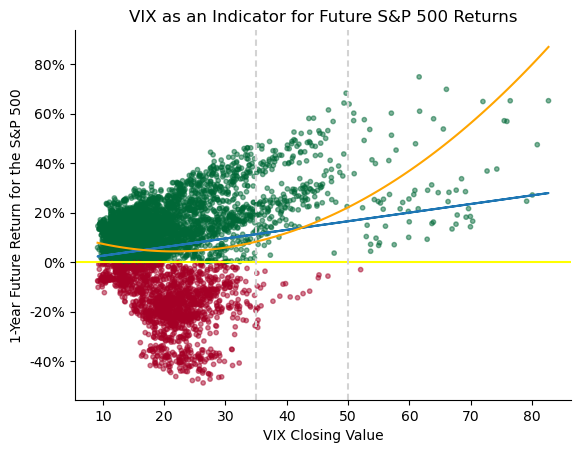

In [51]:
# Draw a scatter plot with linear and non-linear regressions
x=df['^VIX_close'].to_numpy()
y=(df['future_result'].to_numpy())*100
z=df['future_result_boolean'].to_numpy()

# linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)
def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, x))

# non-linear function to fit
def func(x, a, b, c):
    return a*x*x + b*x + c

fig, ax = plt.subplots()
fig.set_dpi(100.0)

# non-linear least squares to fit func to data
p_opt, p_cov = curve_fit(func, x, y)

# these are the fitted values a, b, c
a, b, c = p_opt

# produce 100 values in the range we want to cover along x
x_fit = np.linspace(min(x), max(x), 100)

# compute fitted y values
y_fit = [func(x, a, b, c) for x in x_fit]

# scatter plot
ax.scatter(x, y, c=z, cmap='RdYlGn', alpha=0.5, s=10)
plt.axhline(0, color='yellow')
plt.axvline(35, color='lightgray', dashes=[3, 2])
plt.axvline(50, color='lightgray', dashes=[3, 2])

plt.plot(x, mymodel)
ax.plot(x_fit, y_fit, c="orange")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Format the y ticks with a '%' sign
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)


ax.set_xlabel("VIX Closing Value")
ax.set_ylabel("1-Year Future Return for the S&P 500")
ax.set_title("VIX as an Indicator for Future S&P 500 Returns")

# export the chart
plt.savefig('static/images/vix_sp500_regressions.jpg')

In [16]:
x=df[['^VIX_close']].to_numpy()
y=df[['future_result']].to_numpy()
z=df[['future_result_boolean']].to_numpy()

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.03227622723438528
intercept: [-0.00865402]
slope: [[0.003485]]


In [17]:
y_pred = (model.predict(x))
print(f"predicted response:\n{np.round((y_pred)*100,2)}")

predicted response:
[[7.57]
 [8.55]
 [8.34]
 ...
 [7.51]
 [7.48]
 [8.23]]


In [18]:
# Test model
print("Enter the current VIX closing price: ")
s = input()
n = int(s)
output_array = model.predict([[n]])
formatted_array = np.round(output_array[0]*100, 2)
print(f"The expected {days_in_future_that_result_is_calculated}-day return of the S&P 500 is: ")
for i in formatted_array:
    print(f"{i}%")

Enter the current VIX closing price: 
50
The expected 250-day return of the S&P 500 is: 
16.56%


In [19]:
import pickle

In [20]:
# Export model
pickle.dump(model, open("model.pkl", "wb"))

In [21]:
# Verify model export and import
model = pickle.load( open('model.pkl','rb'))
model_output = model.predict([[n]])
print(model_output)

[[0.16559607]]
